# What this code does
details

## Import ....

In [53]:
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto


In [54]:
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [55]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=1000
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2
font = {
        'size'   : 26}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = nn.Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=nn.Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = nn.Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.relu(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.relu(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.relu(code)
        return result
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.relu(activation)
        for i in range(self.number_of_layers):
             x=torch.relu(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [56]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [57]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

print(model.encoder_input_layer.weight)

cpu
Parameter containing:
tensor([[-0.0272, -0.0119,  0.0016,  ..., -0.0131, -0.0234, -0.0106],
        [-0.0282, -0.0287, -0.0025,  ...,  0.0098, -0.0148,  0.0169],
        [-0.0216, -0.0293, -0.0159,  ..., -0.0187, -0.0164, -0.0283],
        ...,
        [-0.0130,  0.0005, -0.0102,  ..., -0.0003, -0.0059,  0.0300],
        [-0.0095,  0.0104, -0.0090,  ..., -0.0003, -0.0106, -0.0038],
        [-0.0269,  0.0303, -0.0165,  ...,  0.0134, -0.0155,  0.0022]],
       requires_grad=True)


In [58]:
import matplotlib.pyplot as plt 
epochs=1000
asymptotic_repetition=200


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=batch_size,100
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=20

In [59]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    print(noise.size())
    return inputs + noise
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(torch.Size([batch_size,1,N,N]))

    temp=res/np.sqrt(res.var())/input_size*strength
    noise=temp-temp.mean()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,:,:,0]+images
def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            #input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_features).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(5):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            if j==no_of_repetition-1:
                distribution=spectral_distribution(res)
                overall_distribution=np.append(overall_distribution,distribution)
                #print(overall_distribution)
            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution

def spectral_radius(model,initial_input,no_of_repetition,no_of_images):
    result=[]
   
    output=initial_input.to(device)
    product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    for i in range(5):
        
        res=torch.autograd.functional.jacobian(model.internals,initial_input)
        product=torch.matmul(product,res)
        output=model(initial_input)
        initial_input=output
    
    s,v=torch.linalg.eig(product)
    #print(s)
    abs=torch.abs(s)
    
    spectral=np.power(torch.max(abs).item(),1/5)
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))

    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    ave_jac,distribution = asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    np.savetxt("jacobian epoch"+str(epoch)+".txt",distribution)
    print(distribution.size)
    average_jacobian.append(ave_jac)
    x = [ele.real for ele in distribution]
    # extract imaginary part
    y = [ele.imag for ele in distribution]
    
    plt.scatter(x, y)
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    plt.show()
    plt.hist(np.abs(distribution), density=True, bins='auto', histtype='stepfilled')
    plt.yscale("log")
    plt.xscale("log")

    plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    plt.show()

    for i in range(20):
    
        spectral+=spectral_radius(model_clone,x_train[i],no_of_repetition,no_of_images)
    
    spectral_radiuses.append(spectral/20)
    print(spectral/20)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
    lowest=10**10
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model.internals(x_train_perturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        diff=0
        divergent=0
        #if i ==no_of_repetition-1:
         #   for j in range(no_of_image):
          #      divergent+=divergence(hiddens[j])
                
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            diff+=result
            if result>cutoff and i==no_of_repetition-1:
                chaos+=1
            
        distance.append(diff.cpu().detach().numpy()/no_of_image)
     
        hidden_layer
    return distance,hidden_layer,chaos/no_of_image,divergent

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0
#def spectral_radius(input_matrix):
 #   result=[]
#
 #   s,v=torch.linalg.eig(input_matrix)
  #  #print(s)
   # abs=torch.abs(s)
   # spectral=torch.max(abs).item()
   # return spectral
def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    for i in range(len(s)):
        if s[i].real<2**-49 and s[i].imag<2**-49:
            count+=1
   # print(s)
    s=s[:-count]
    #print(s)
    return s



running
epoch : 1/1000, training loss = 0.106387,validation loss = 0.086992
epoch : 2/1000, training loss = 0.077895,validation loss = 0.062540
epoch : 3/1000, training loss = 0.053431,validation loss = 0.045976
epoch : 4/1000, training loss = 0.039509,validation loss = 0.035067
epoch : 5/1000, training loss = 0.033402,validation loss = 0.032328
epoch : 6/1000, training loss = 0.030716,validation loss = 0.029778
epoch : 7/1000, training loss = 0.029121,validation loss = 0.030154
epoch : 8/1000, training loss = 0.027906,validation loss = 0.028110
epoch : 9/1000, training loss = 0.026536,validation loss = 0.025919
epoch : 10/1000, training loss = 0.025505,validation loss = 0.025144
epoch : 11/1000, training loss = 0.024887,validation loss = 0.024785
epoch : 12/1000, training loss = 0.024510,validation loss = 0.024544
epoch : 13/1000, training loss = 0.024363,validation loss = 0.024453
epoch : 14/1000, training loss = 0.023931,validation loss = 0.023681
epoch : 15/1000, training loss = 0.

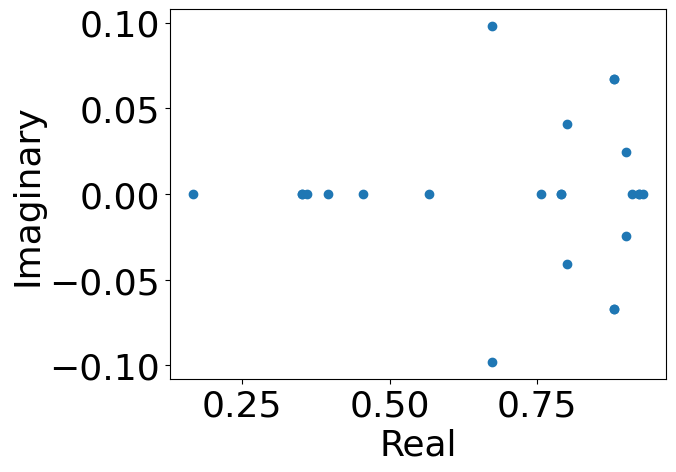

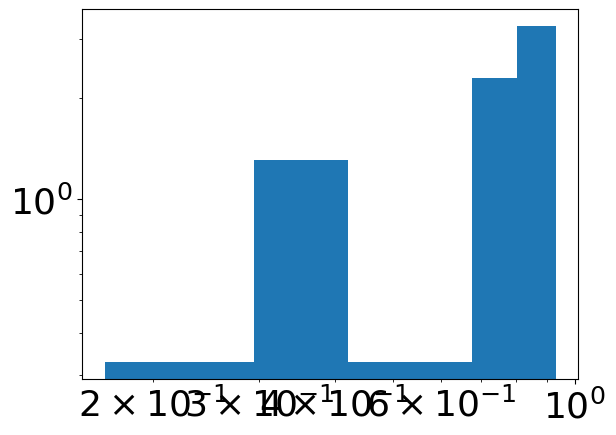

0.9516560309558202
percentage of chaos: 0.987
percentage of convergent: 0.0
12.27536040371553


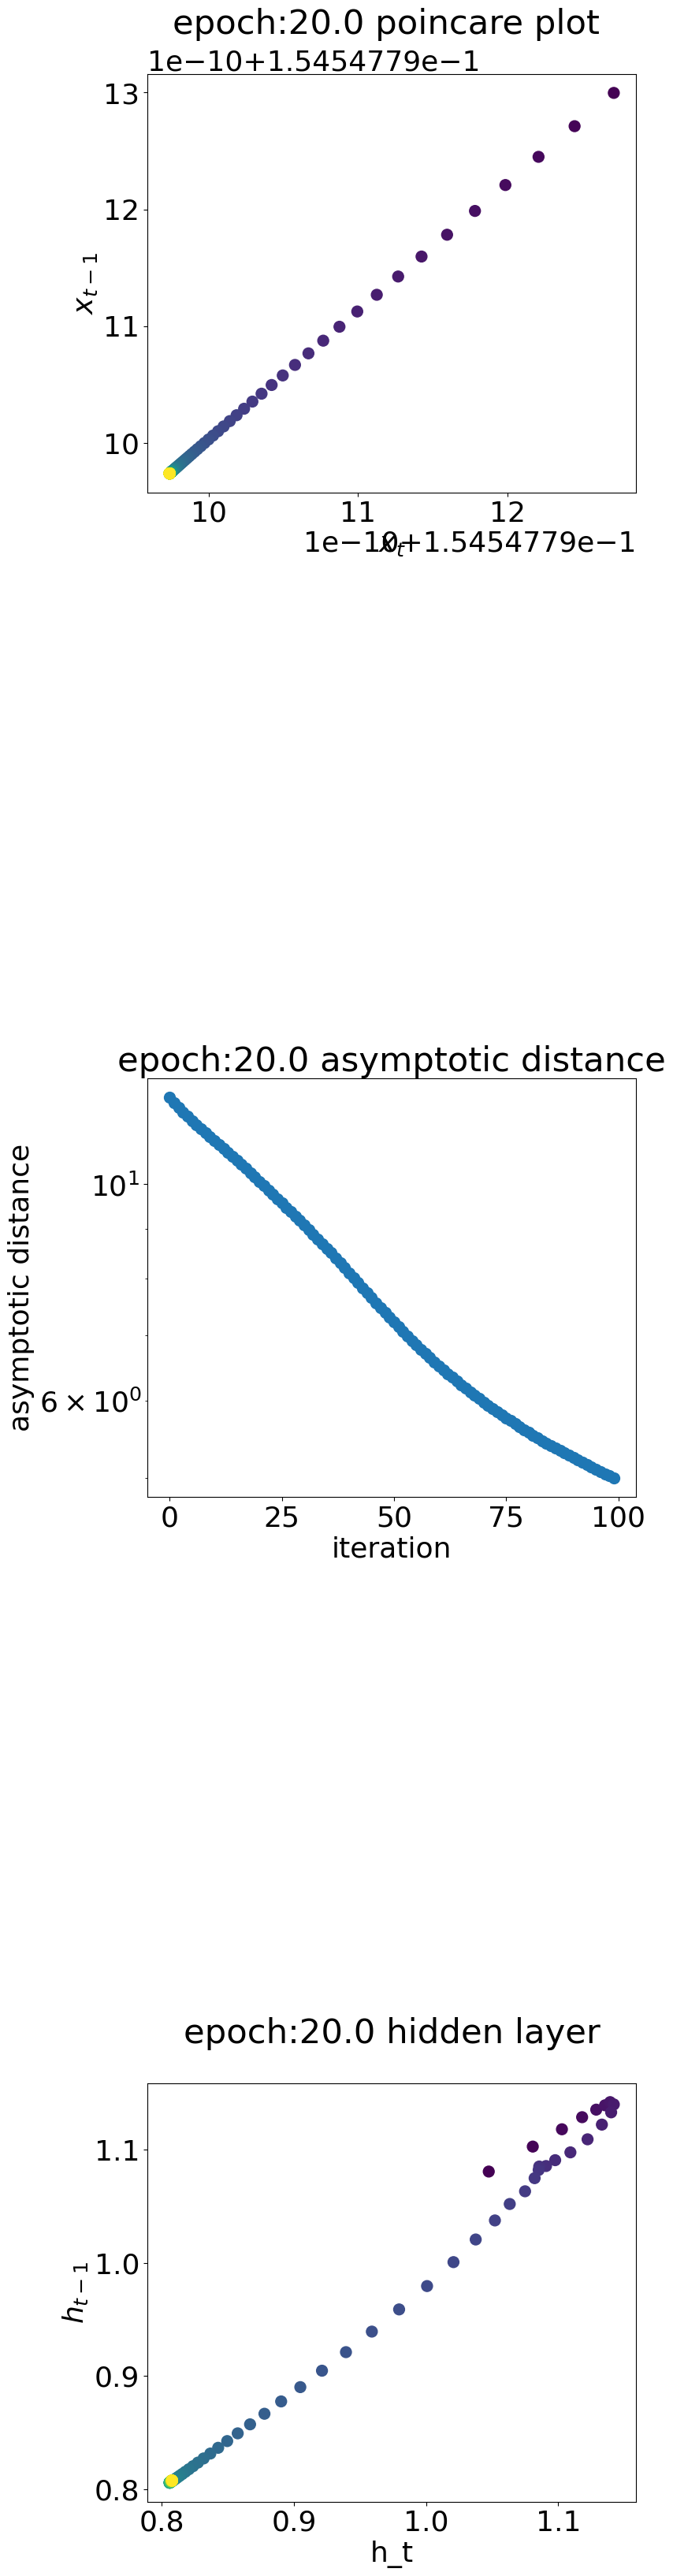

epoch : 21/1000, training loss = 0.020650,validation loss = 0.020561
epoch : 22/1000, training loss = 0.020474,validation loss = 0.020518
epoch : 23/1000, training loss = 0.020197,validation loss = 0.020411
epoch : 24/1000, training loss = 0.020041,validation loss = 0.020209
epoch : 25/1000, training loss = 0.019873,validation loss = 0.020034
epoch : 26/1000, training loss = 0.019732,validation loss = 0.020200
epoch : 27/1000, training loss = 0.019768,validation loss = 0.020093
epoch : 28/1000, training loss = 0.019621,validation loss = 0.019635
epoch : 29/1000, training loss = 0.019287,validation loss = 0.019425
epoch : 30/1000, training loss = 0.018987,validation loss = 0.019063
epoch : 31/1000, training loss = 0.018849,validation loss = 0.019044
epoch : 32/1000, training loss = 0.018645,validation loss = 0.019639
epoch : 33/1000, training loss = 0.018742,validation loss = 0.018834
epoch : 34/1000, training loss = 0.018461,validation loss = 0.018752
epoch : 35/1000, training loss = 0

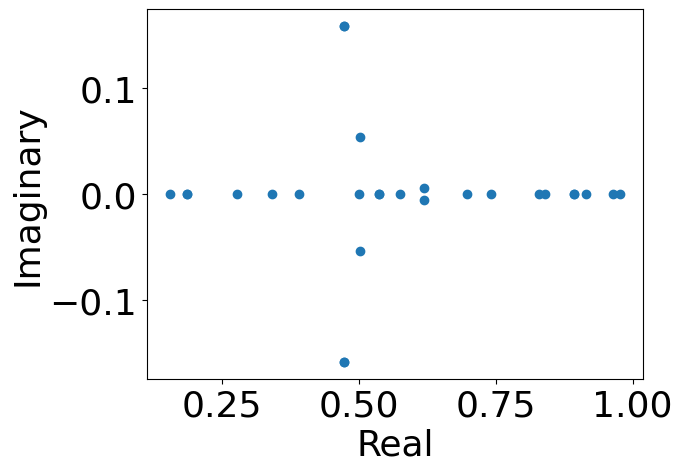

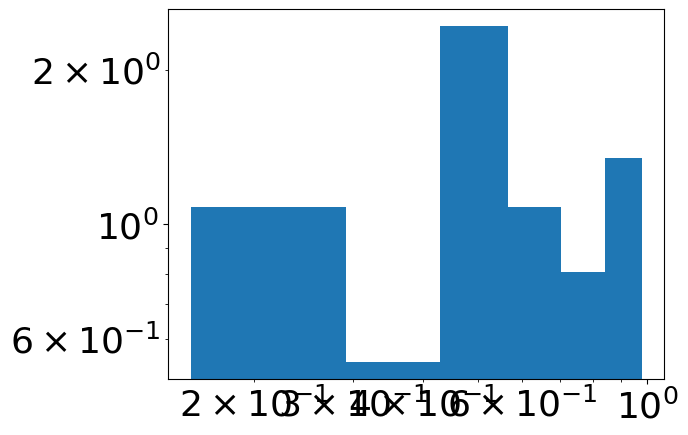

0.965644636041666
percentage of chaos: 0.959
percentage of convergent: 0.0
12.87486433040843


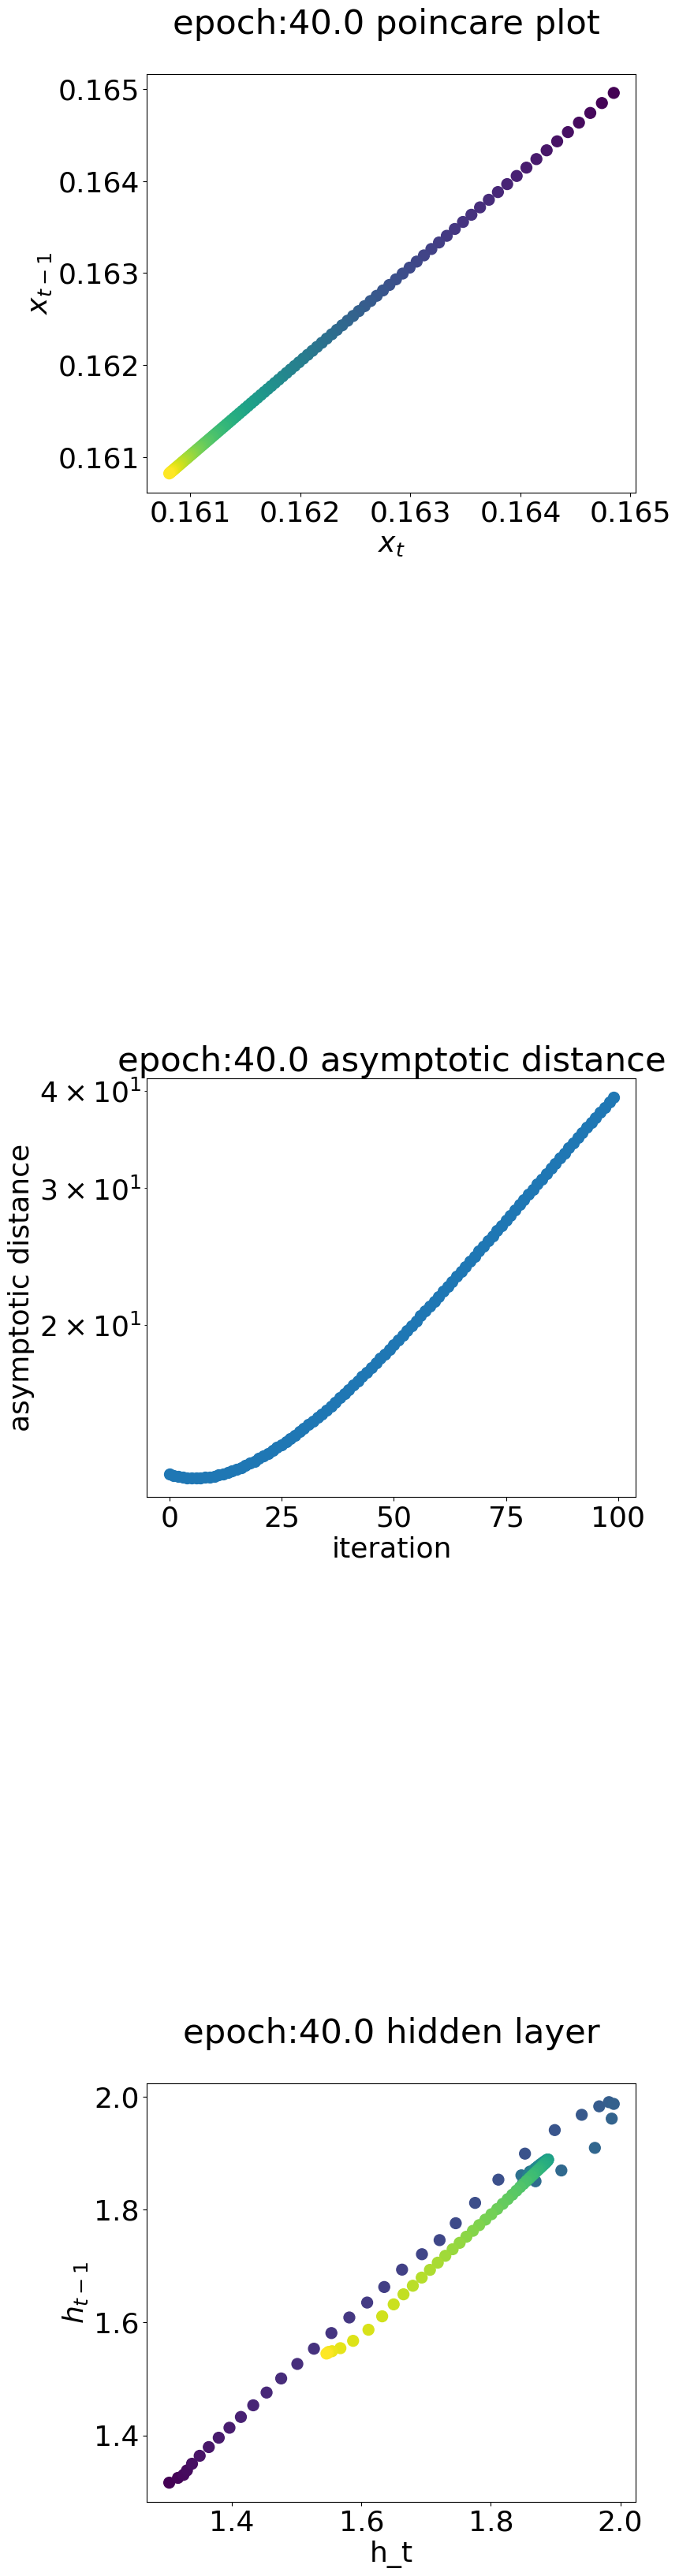

epoch : 41/1000, training loss = 0.017177,validation loss = 0.017579
epoch : 42/1000, training loss = 0.017092,validation loss = 0.017714
epoch : 43/1000, training loss = 0.017121,validation loss = 0.017827
epoch : 44/1000, training loss = 0.017214,validation loss = 0.017528
epoch : 45/1000, training loss = 0.017152,validation loss = 0.017636
epoch : 46/1000, training loss = 0.017136,validation loss = 0.017451
epoch : 47/1000, training loss = 0.016991,validation loss = 0.017375
epoch : 48/1000, training loss = 0.016883,validation loss = 0.017300
epoch : 49/1000, training loss = 0.016797,validation loss = 0.017229
epoch : 50/1000, training loss = 0.016700,validation loss = 0.017296
epoch : 51/1000, training loss = 0.016638,validation loss = 0.017273
epoch : 52/1000, training loss = 0.016663,validation loss = 0.017542
epoch : 53/1000, training loss = 0.016692,validation loss = 0.017218
epoch : 54/1000, training loss = 0.016760,validation loss = 0.017394
epoch : 55/1000, training loss = 0

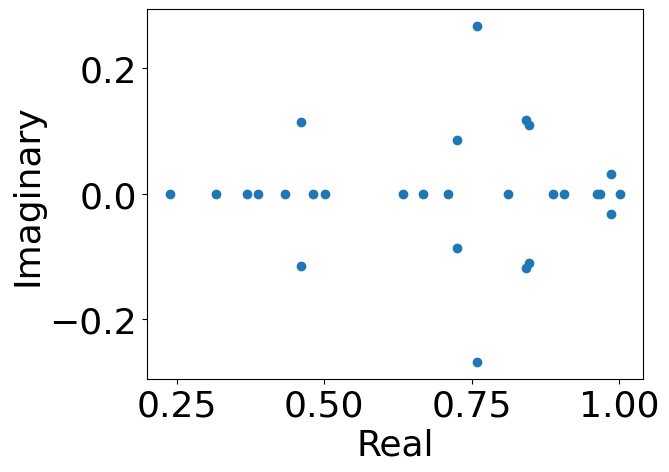

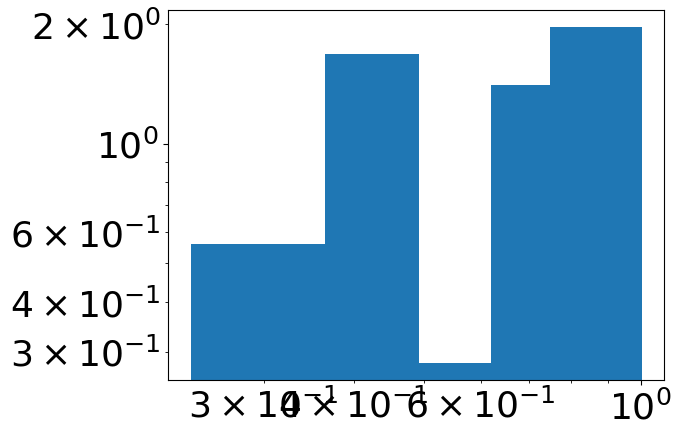

0.9780491882860582
percentage of chaos: 0.151
percentage of convergent: 0.0
150350.30842083867


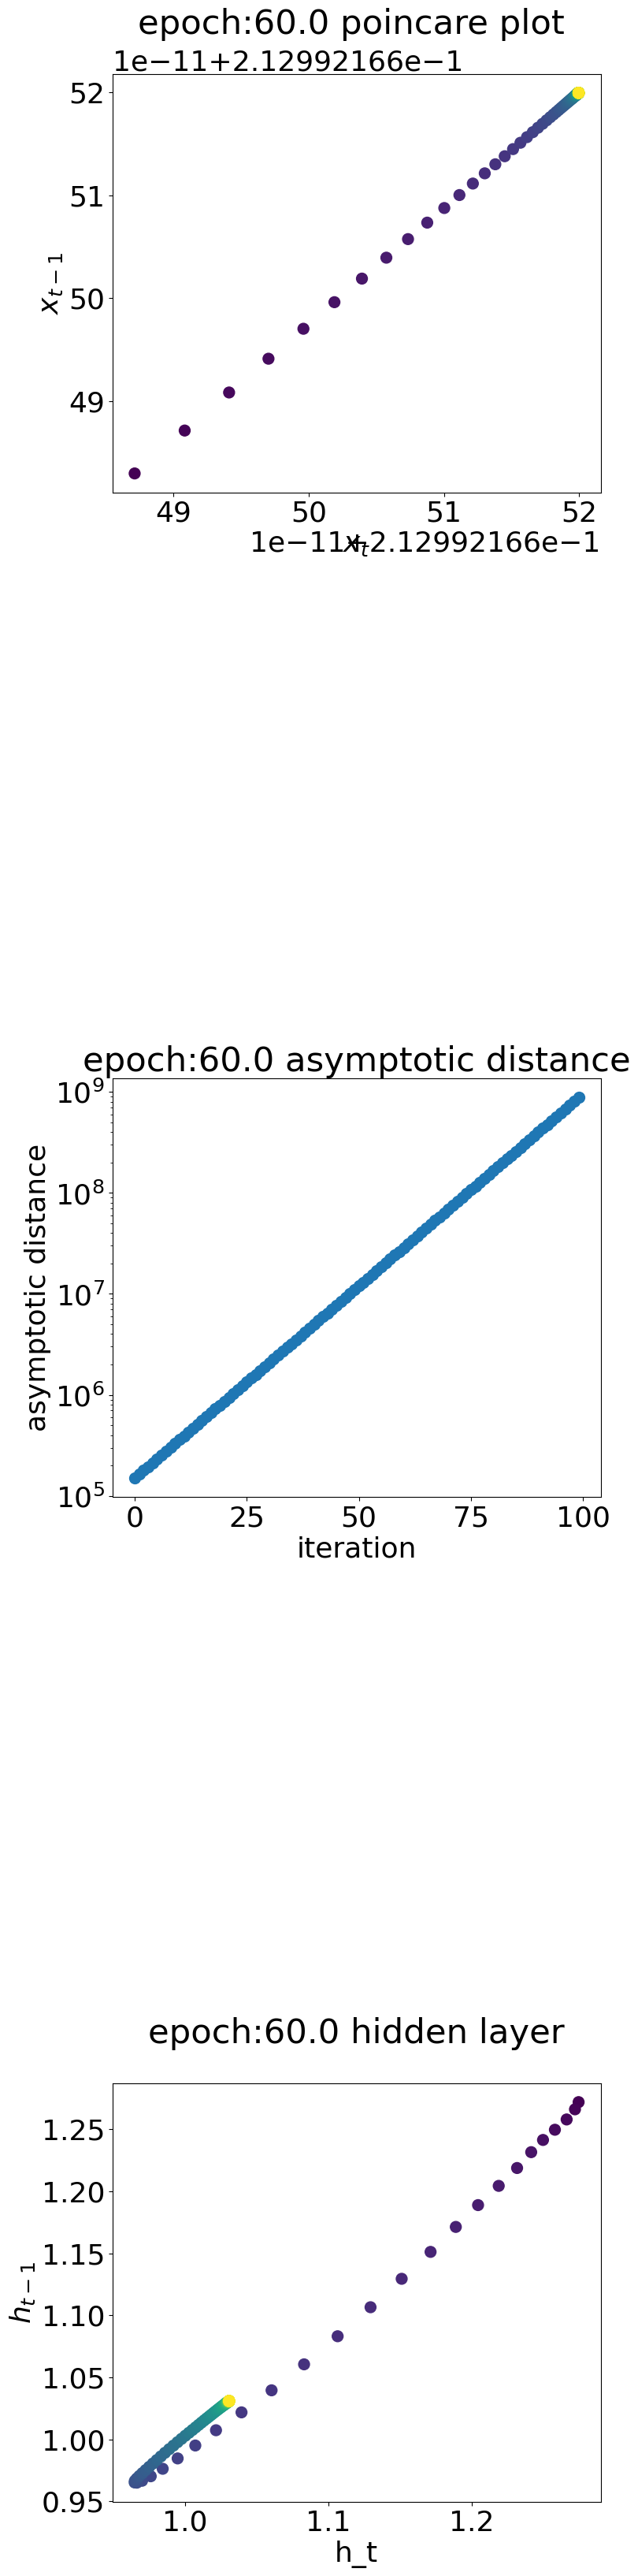

epoch : 61/1000, training loss = 0.016337,validation loss = 0.016938
epoch : 62/1000, training loss = 0.016271,validation loss = 0.016947
epoch : 63/1000, training loss = 0.016213,validation loss = 0.016973
epoch : 64/1000, training loss = 0.016329,validation loss = 0.016927
epoch : 65/1000, training loss = 0.016360,validation loss = 0.017443
epoch : 66/1000, training loss = 0.016450,validation loss = 0.017250
epoch : 67/1000, training loss = 0.016335,validation loss = 0.017132
epoch : 68/1000, training loss = 0.016281,validation loss = 0.017066
epoch : 69/1000, training loss = 0.016277,validation loss = 0.017283
epoch : 70/1000, training loss = 0.016284,validation loss = 0.016871
epoch : 71/1000, training loss = 0.016283,validation loss = 0.016943
epoch : 72/1000, training loss = 0.016170,validation loss = 0.016886
epoch : 73/1000, training loss = 0.016062,validation loss = 0.016781
epoch : 74/1000, training loss = 0.016035,validation loss = 0.016842
epoch : 75/1000, training loss = 0

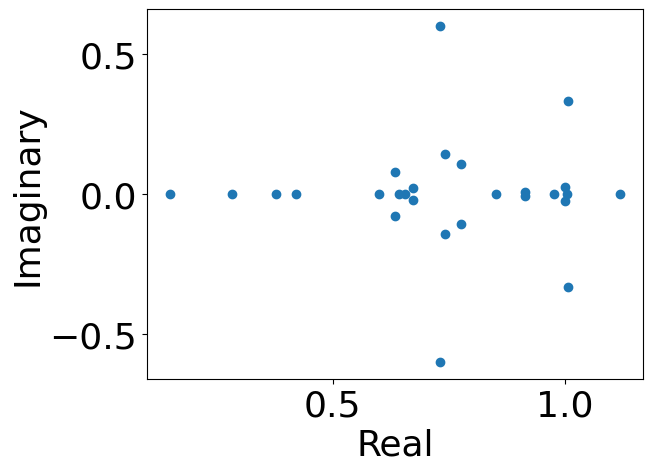

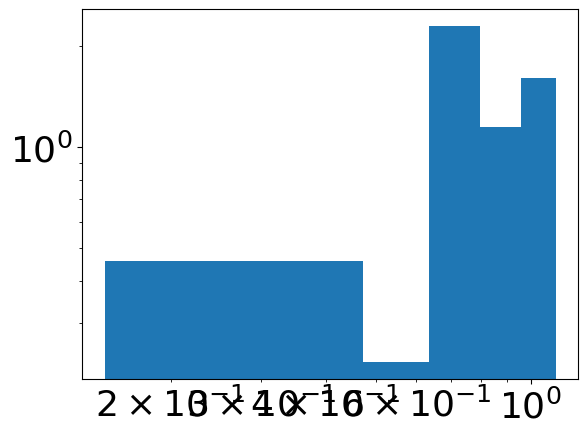

1.00501501810151
percentage of chaos: 0.414
percentage of convergent: 0.0
16967.708214771395


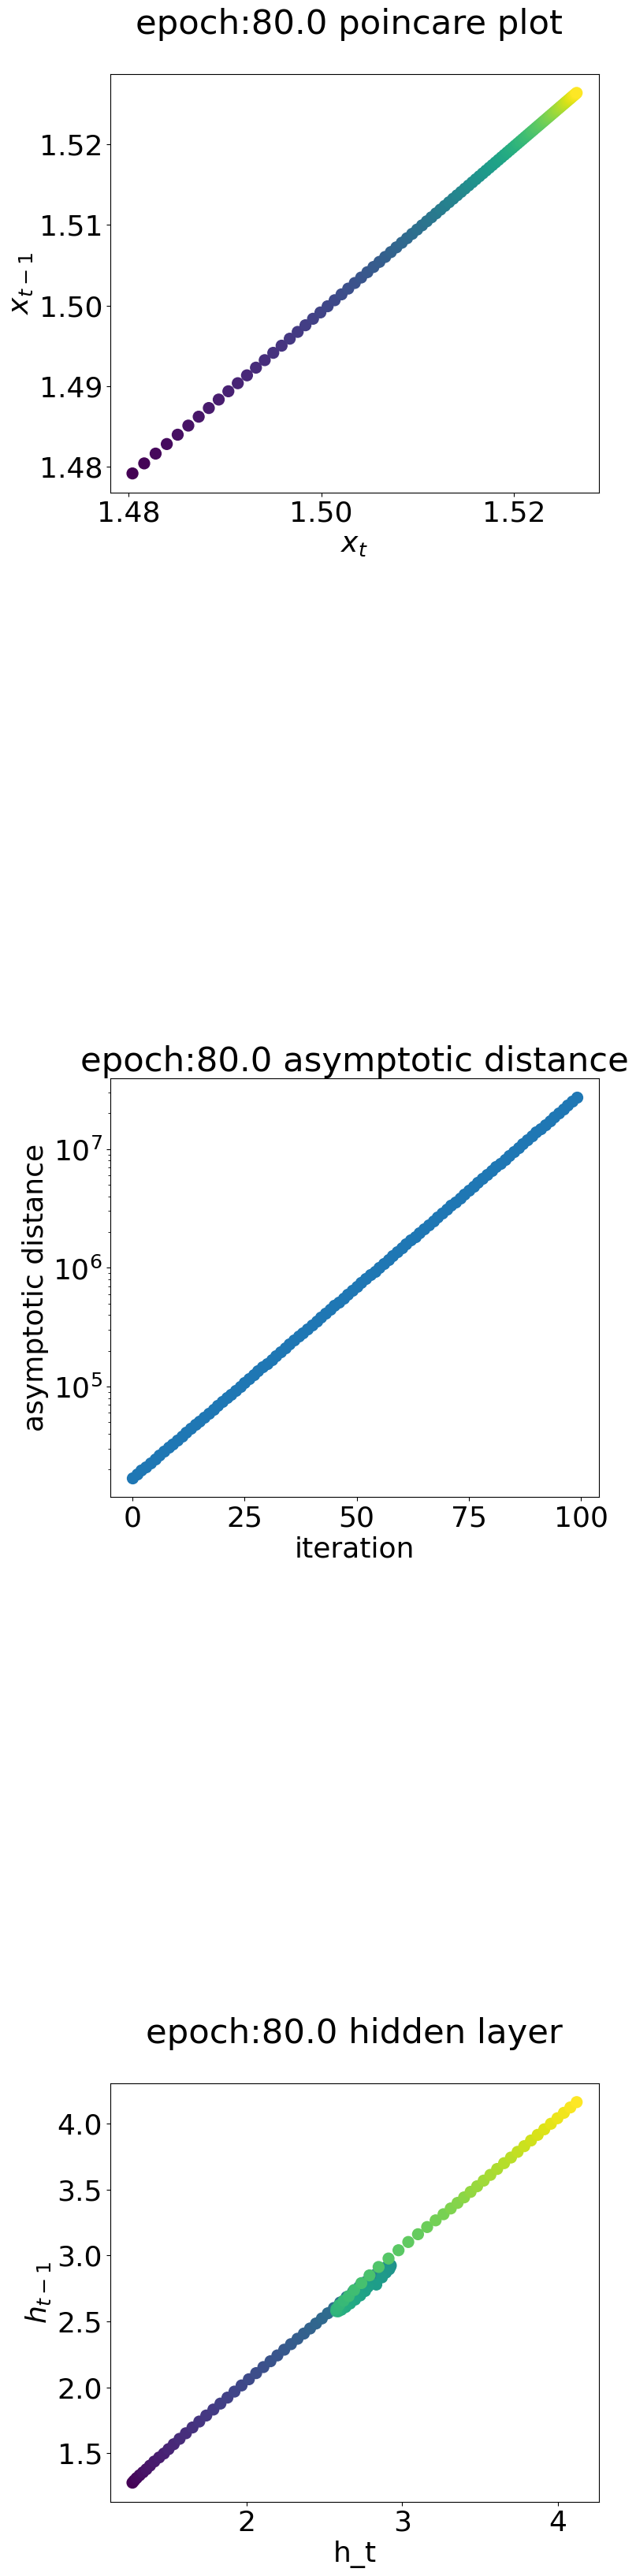

epoch : 81/1000, training loss = 0.015436,validation loss = 0.016192
epoch : 82/1000, training loss = 0.015368,validation loss = 0.016230
epoch : 83/1000, training loss = 0.015336,validation loss = 0.016448
epoch : 84/1000, training loss = 0.015332,validation loss = 0.016322
epoch : 85/1000, training loss = 0.015425,validation loss = 0.016441
epoch : 86/1000, training loss = 0.015444,validation loss = 0.016445
epoch : 87/1000, training loss = 0.015603,validation loss = 0.016430
epoch : 88/1000, training loss = 0.015560,validation loss = 0.016296
epoch : 89/1000, training loss = 0.015452,validation loss = 0.016316
epoch : 90/1000, training loss = 0.015460,validation loss = 0.016404
epoch : 91/1000, training loss = 0.015440,validation loss = 0.016382
epoch : 92/1000, training loss = 0.015343,validation loss = 0.016539
epoch : 93/1000, training loss = 0.015410,validation loss = 0.016283
epoch : 94/1000, training loss = 0.015345,validation loss = 0.016266
epoch : 95/1000, training loss = 0

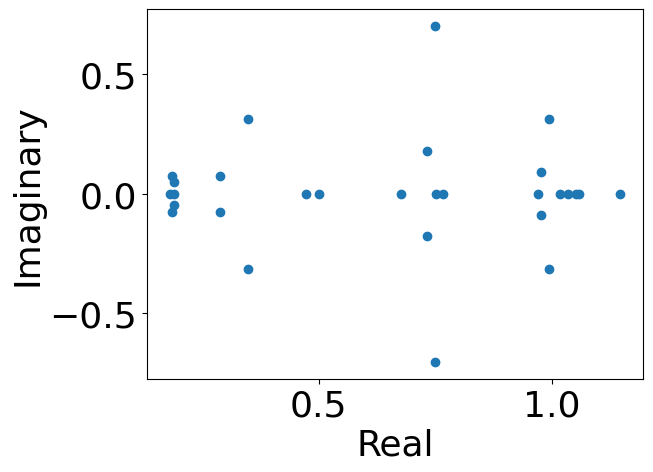

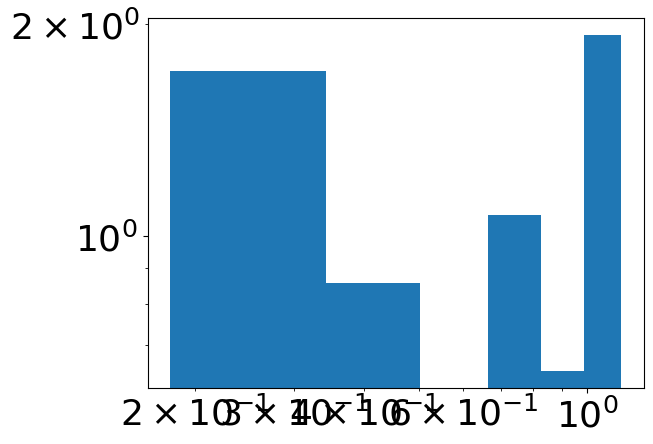

1.0112918408102751
percentage of chaos: 0.212
percentage of convergent: 0.0
6061773945.993079


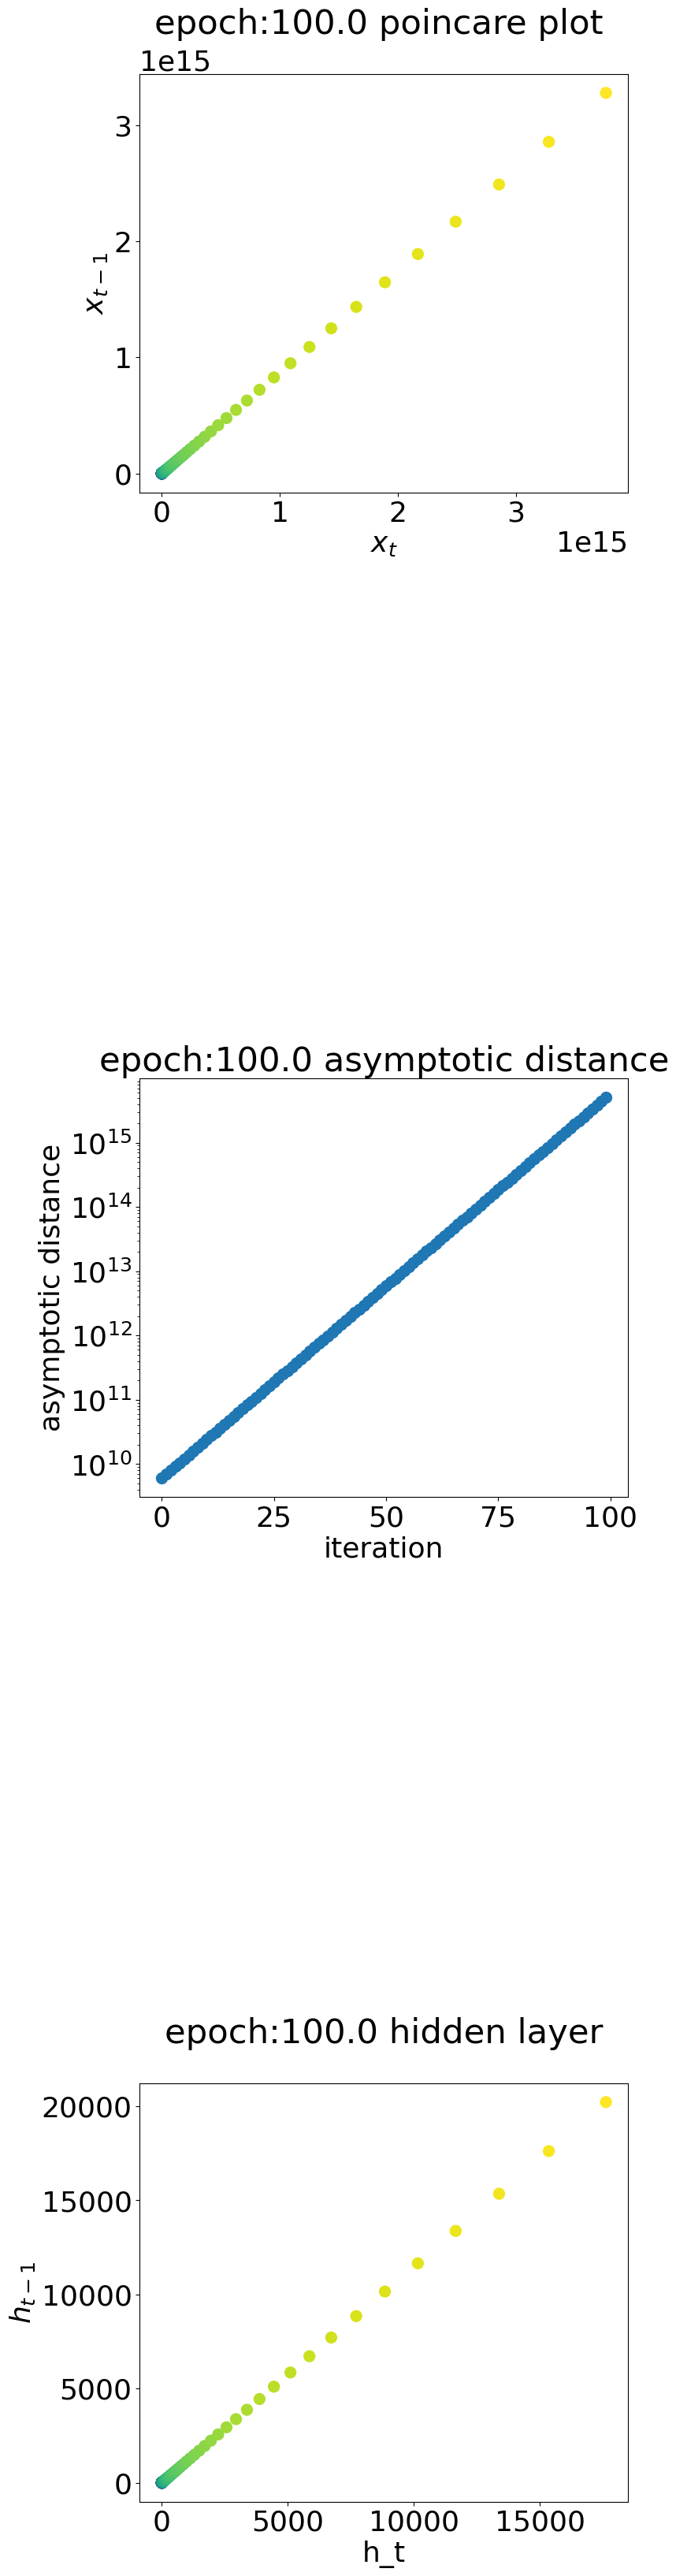

epoch : 101/1000, training loss = 0.015242,validation loss = 0.016121
epoch : 102/1000, training loss = 0.015209,validation loss = 0.016046
epoch : 103/1000, training loss = 0.015000,validation loss = 0.016012
epoch : 104/1000, training loss = 0.014952,validation loss = 0.016037
epoch : 105/1000, training loss = 0.014965,validation loss = 0.016172
epoch : 106/1000, training loss = 0.014989,validation loss = 0.016155
epoch : 107/1000, training loss = 0.015025,validation loss = 0.016221
epoch : 108/1000, training loss = 0.015121,validation loss = 0.016496
epoch : 109/1000, training loss = 0.015307,validation loss = 0.016449
epoch : 110/1000, training loss = 0.015233,validation loss = 0.016196
epoch : 111/1000, training loss = 0.015071,validation loss = 0.016267
epoch : 112/1000, training loss = 0.014940,validation loss = 0.016117
epoch : 113/1000, training loss = 0.015087,validation loss = 0.016062
epoch : 114/1000, training loss = 0.014872,validation loss = 0.016006
epoch : 115/1000, tr

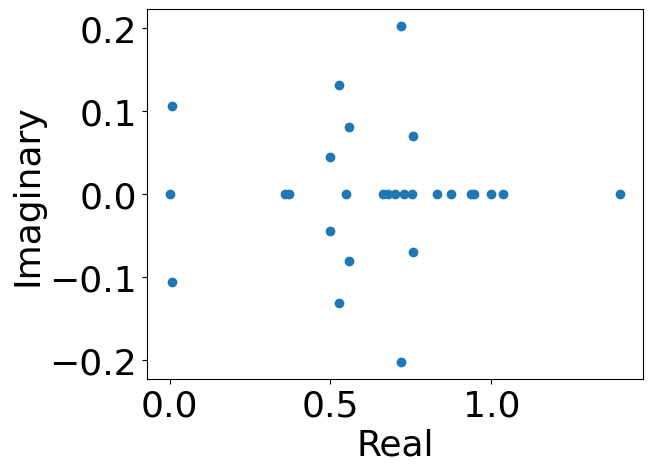

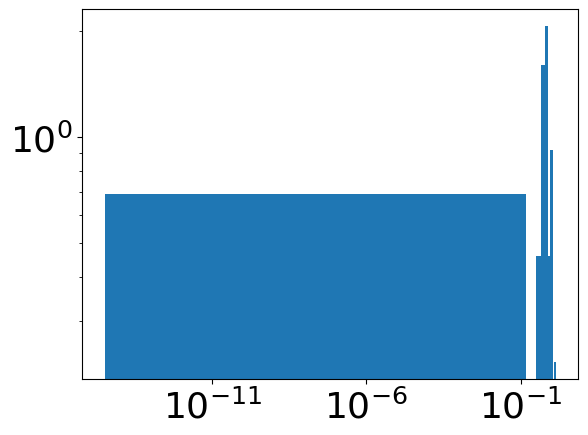

1.0001944623420145
percentage of chaos: 0.224
percentage of convergent: 0.0
662405.7584004558


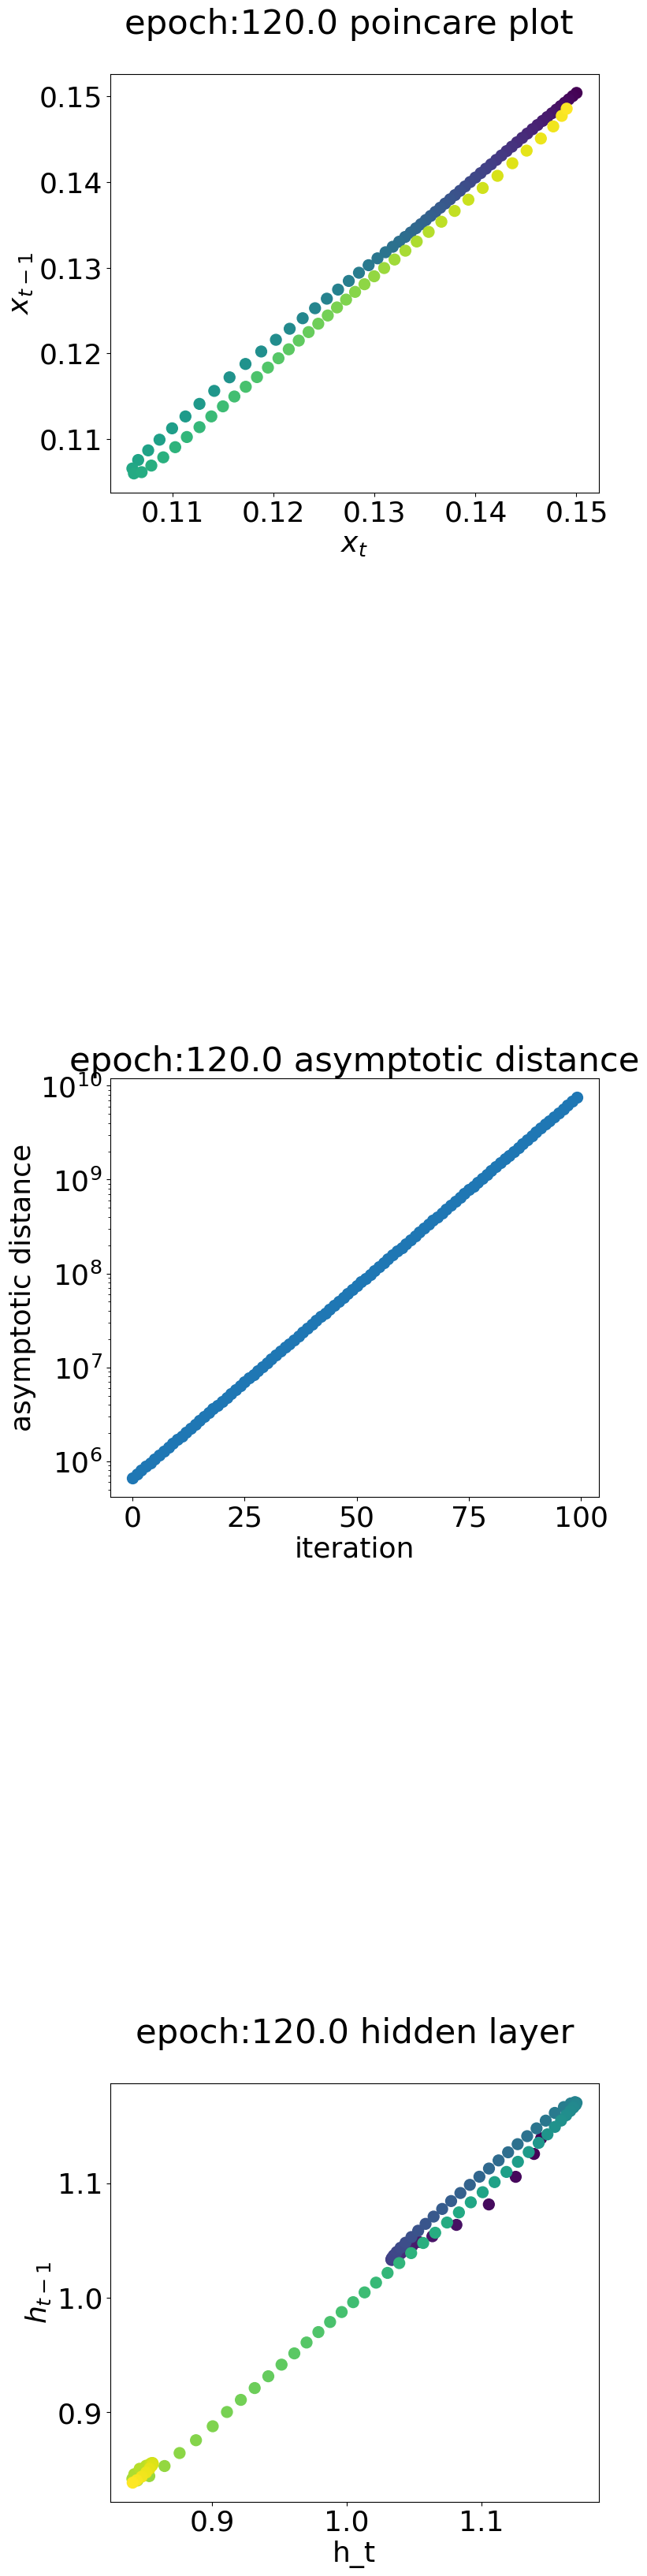

epoch : 121/1000, training loss = 0.014880,validation loss = 0.016020
epoch : 122/1000, training loss = 0.014833,validation loss = 0.016176
epoch : 123/1000, training loss = 0.014708,validation loss = 0.016017
epoch : 124/1000, training loss = 0.014669,validation loss = 0.015957
epoch : 125/1000, training loss = 0.014656,validation loss = 0.015914
epoch : 126/1000, training loss = 0.014612,validation loss = 0.015950
epoch : 127/1000, training loss = 0.014557,validation loss = 0.015932
epoch : 128/1000, training loss = 0.014506,validation loss = 0.015982
epoch : 129/1000, training loss = 0.014496,validation loss = 0.015958
epoch : 130/1000, training loss = 0.014573,validation loss = 0.016086
epoch : 131/1000, training loss = 0.014636,validation loss = 0.015989
epoch : 132/1000, training loss = 0.014724,validation loss = 0.016017
epoch : 133/1000, training loss = 0.014834,validation loss = 0.015994
epoch : 134/1000, training loss = 0.014818,validation loss = 0.016175
epoch : 135/1000, tr

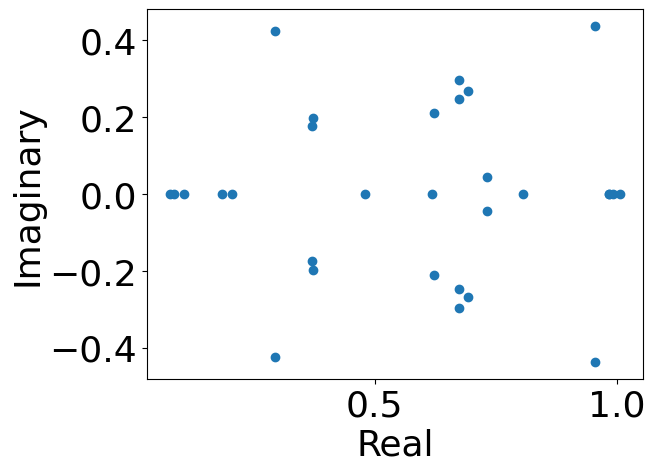

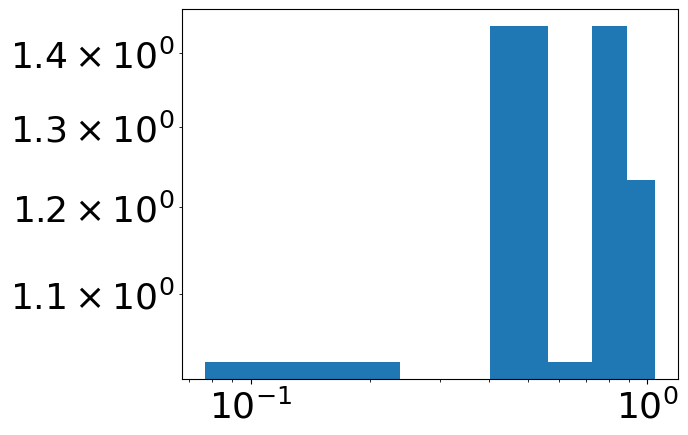

0.9810064006957633
percentage of chaos: 0.818
percentage of convergent: 0.0
68.66542804922126


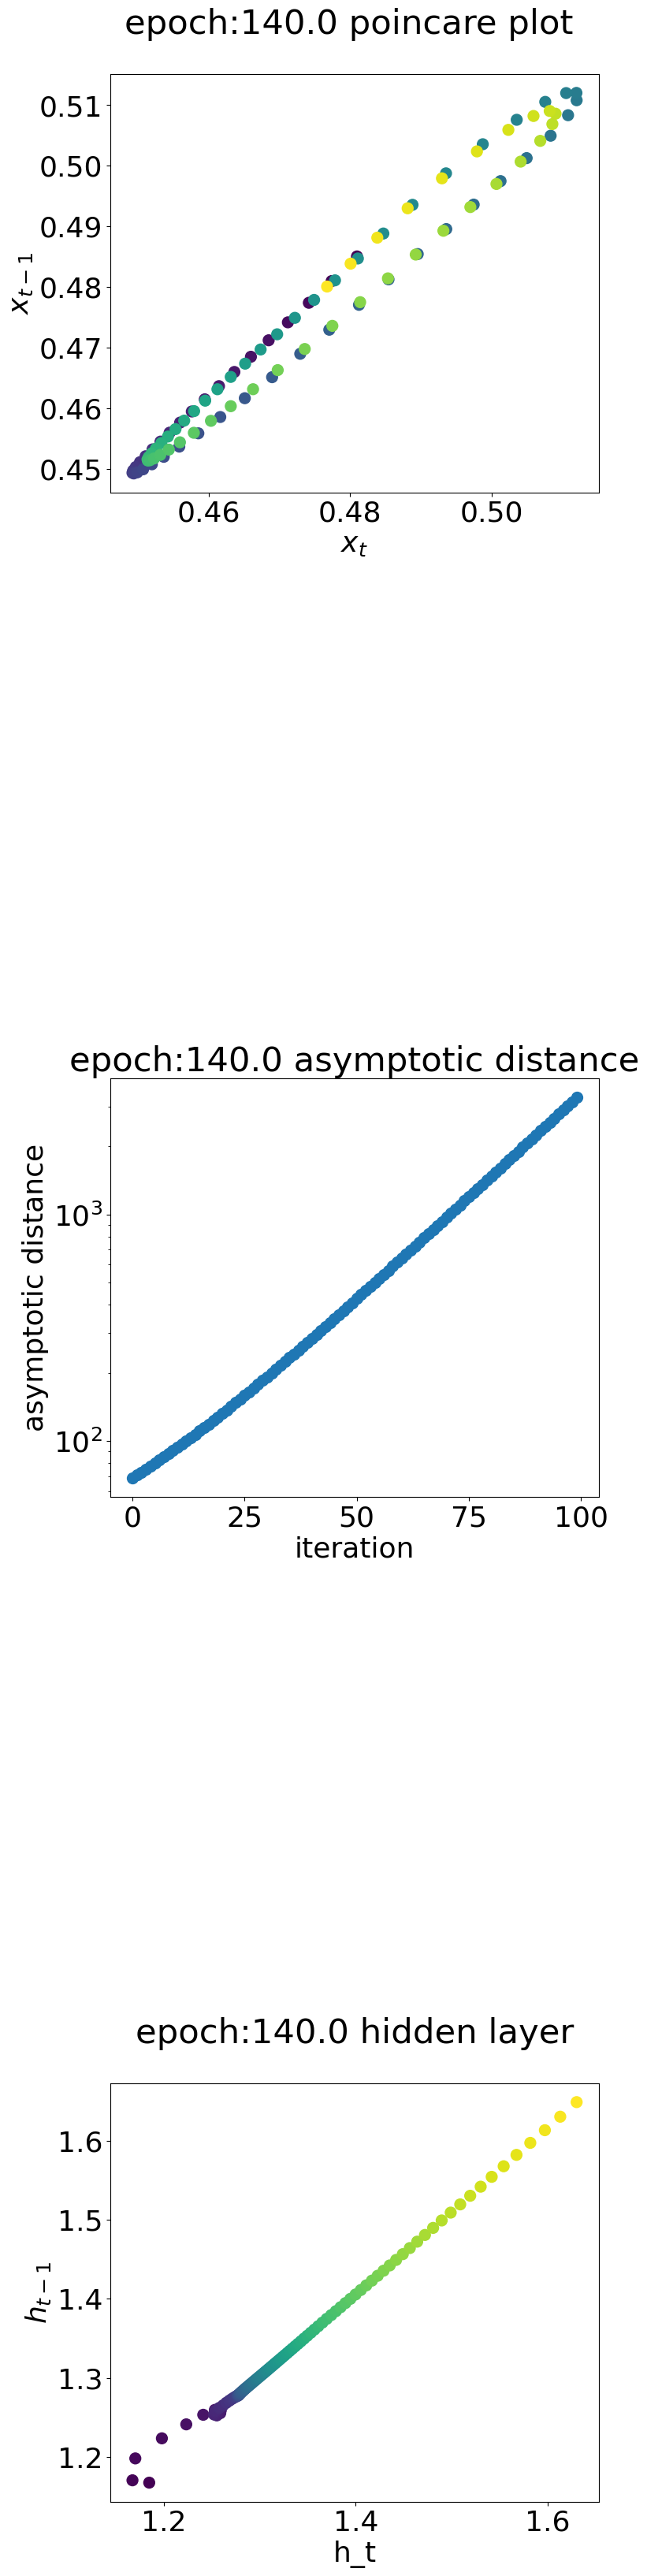

epoch : 141/1000, training loss = 0.014374,validation loss = 0.015925
epoch : 142/1000, training loss = 0.014546,validation loss = 0.016148
epoch : 143/1000, training loss = 0.014664,validation loss = 0.016144
epoch : 144/1000, training loss = 0.014602,validation loss = 0.015921
epoch : 145/1000, training loss = 0.014428,validation loss = 0.015950
epoch : 146/1000, training loss = 0.014378,validation loss = 0.015916
epoch : 147/1000, training loss = 0.014337,validation loss = 0.015846
epoch : 148/1000, training loss = 0.014366,validation loss = 0.015853
epoch : 149/1000, training loss = 0.014485,validation loss = 0.015913
epoch : 150/1000, training loss = 0.014300,validation loss = 0.015799
epoch : 151/1000, training loss = 0.014184,validation loss = 0.015825
epoch : 152/1000, training loss = 0.014129,validation loss = 0.015787
epoch : 153/1000, training loss = 0.014103,validation loss = 0.015758
epoch : 154/1000, training loss = 0.014108,validation loss = 0.015793
epoch : 155/1000, tr

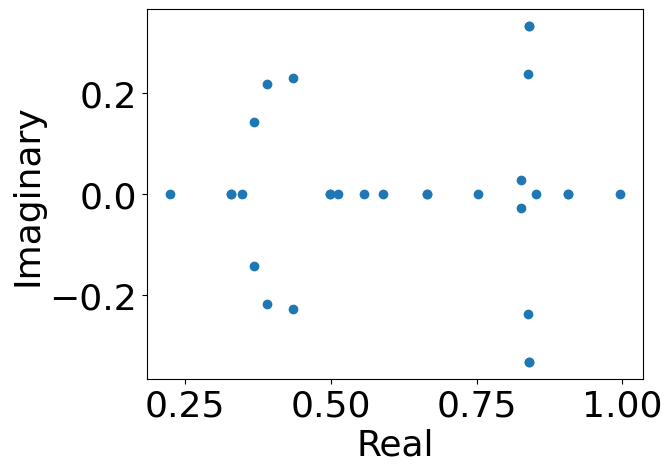

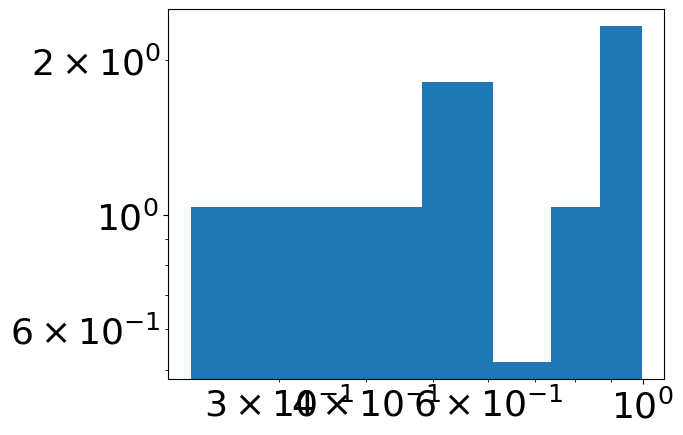

0.9312725735967537
percentage of chaos: 0.026
percentage of convergent: 0.0
4163753.266275385


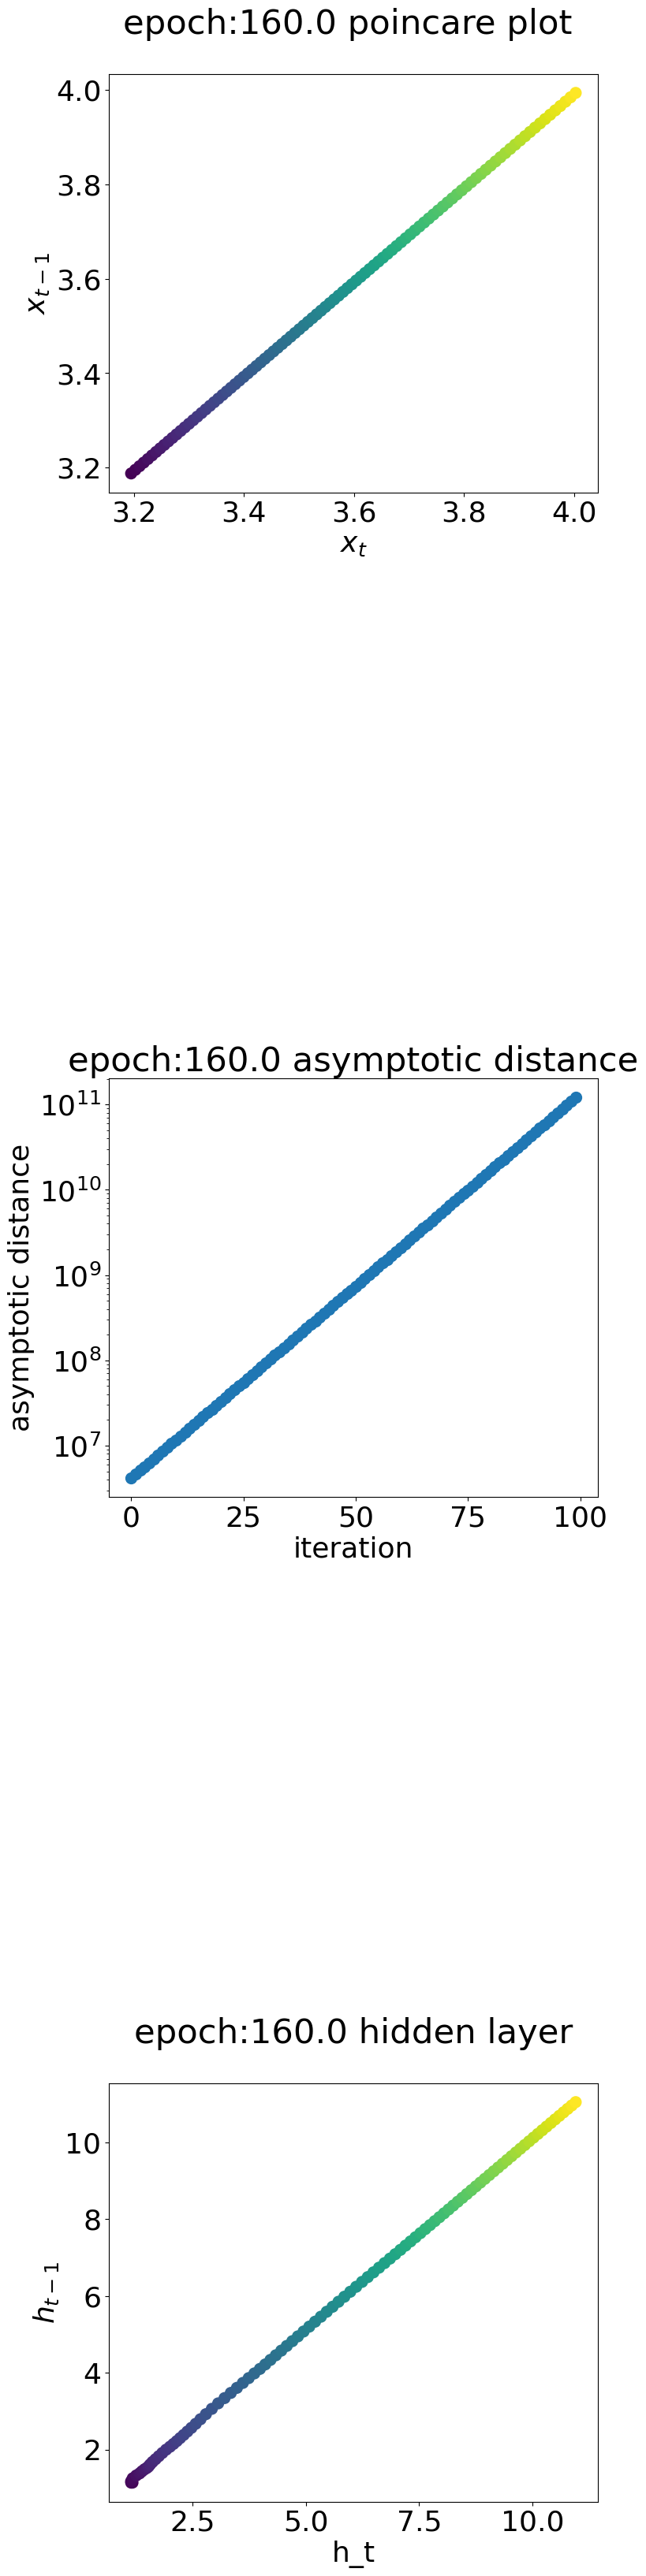

epoch : 161/1000, training loss = 0.014288,validation loss = 0.015846
epoch : 162/1000, training loss = 0.014067,validation loss = 0.015653
epoch : 163/1000, training loss = 0.013925,validation loss = 0.015702
epoch : 164/1000, training loss = 0.013691,validation loss = 0.015437
epoch : 165/1000, training loss = 0.013619,validation loss = 0.015420
epoch : 166/1000, training loss = 0.013616,validation loss = 0.015415
epoch : 167/1000, training loss = 0.013643,validation loss = 0.015435
epoch : 168/1000, training loss = 0.013776,validation loss = 0.015379
epoch : 169/1000, training loss = 0.014000,validation loss = 0.015561
epoch : 170/1000, training loss = 0.014084,validation loss = 0.015782
epoch : 171/1000, training loss = 0.013986,validation loss = 0.015414
epoch : 172/1000, training loss = 0.013766,validation loss = 0.015319
epoch : 173/1000, training loss = 0.013455,validation loss = 0.015071
epoch : 174/1000, training loss = 0.013305,validation loss = 0.015096
epoch : 175/1000, tr

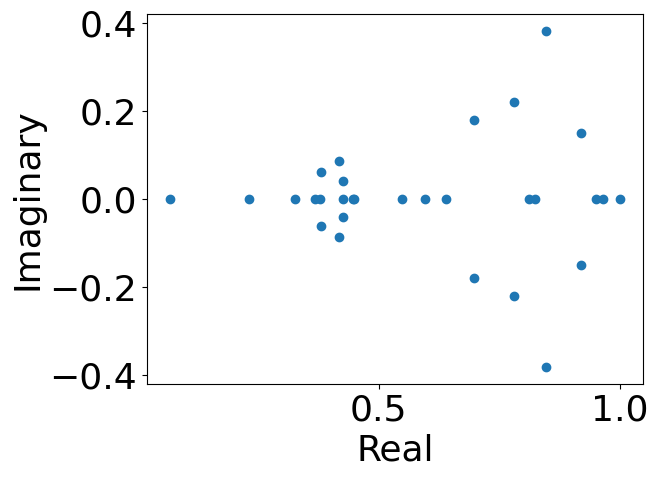

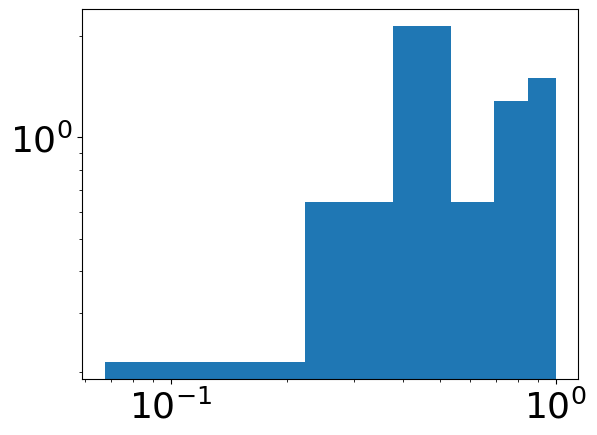

0.9294581143716542
percentage of chaos: 0.891
percentage of convergent: 0.0
12.42988923702519


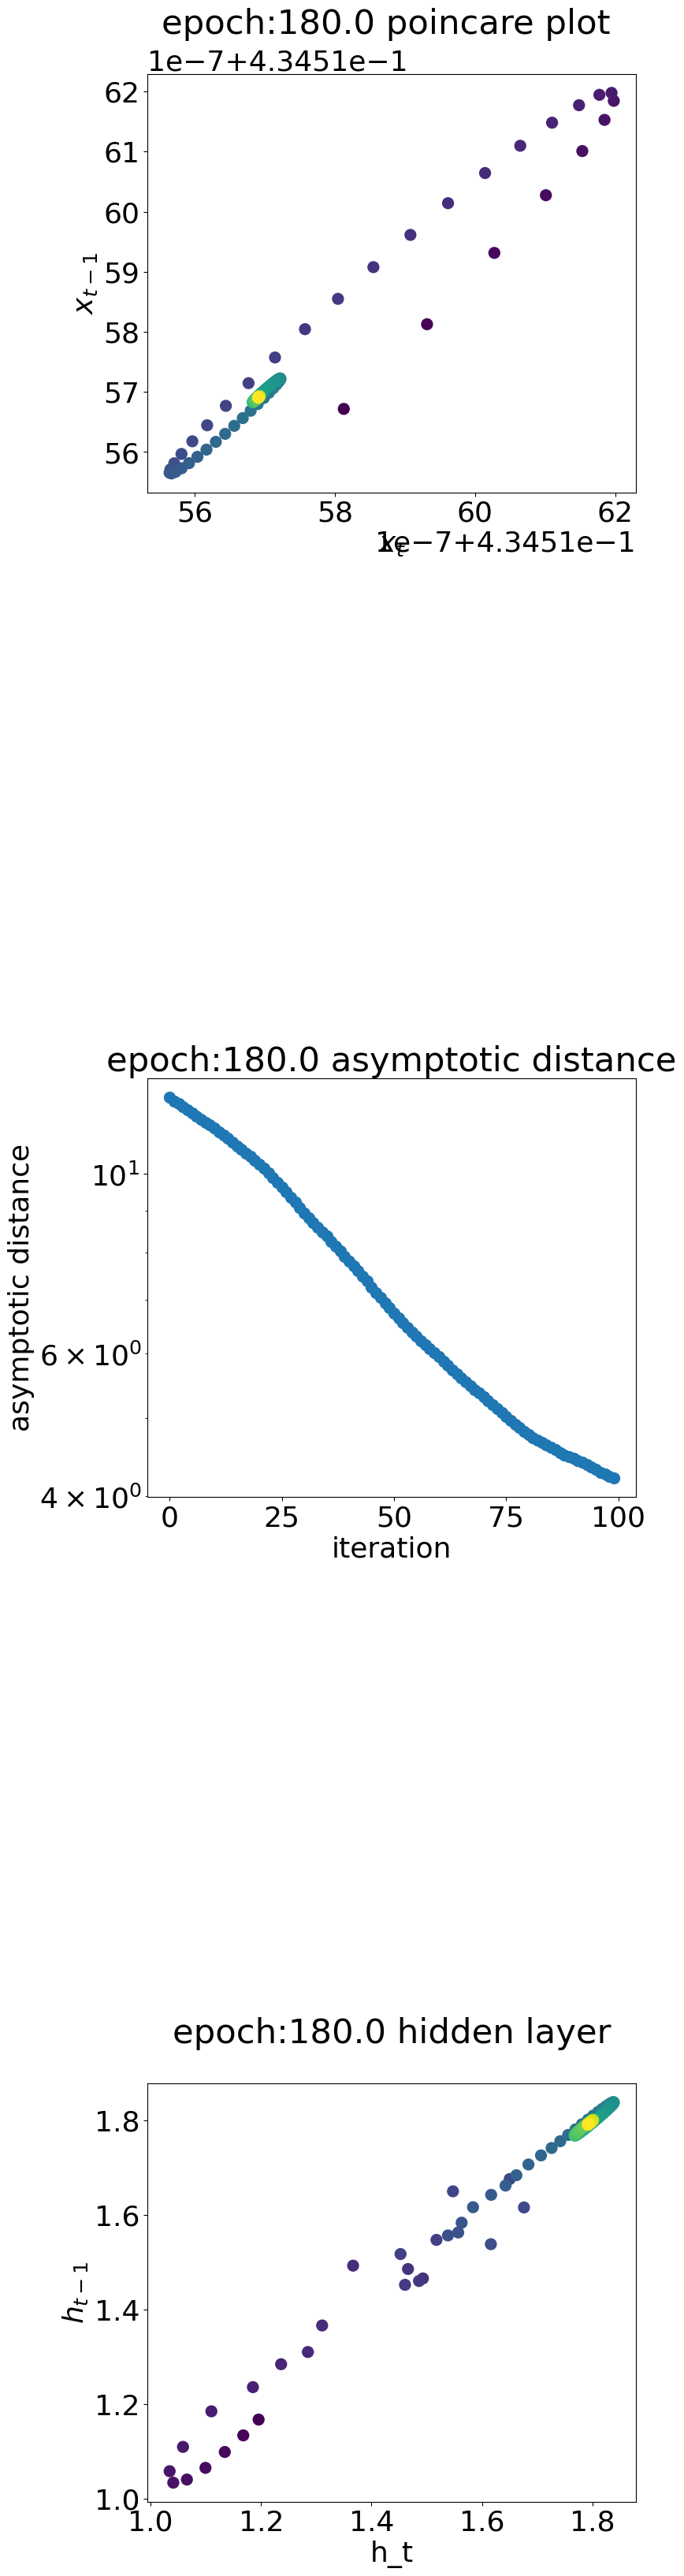

epoch : 181/1000, training loss = 0.013691,validation loss = 0.015577
epoch : 182/1000, training loss = 0.013617,validation loss = 0.015415
epoch : 183/1000, training loss = 0.013493,validation loss = 0.015314
epoch : 184/1000, training loss = 0.013540,validation loss = 0.015234
epoch : 185/1000, training loss = 0.013585,validation loss = 0.015249
epoch : 186/1000, training loss = 0.013520,validation loss = 0.015150
epoch : 187/1000, training loss = 0.013452,validation loss = 0.015092
epoch : 188/1000, training loss = 0.013465,validation loss = 0.015233
epoch : 189/1000, training loss = 0.013365,validation loss = 0.015094
epoch : 190/1000, training loss = 0.013218,validation loss = 0.015022
epoch : 191/1000, training loss = 0.013113,validation loss = 0.014962
epoch : 192/1000, training loss = 0.013048,validation loss = 0.014971
epoch : 193/1000, training loss = 0.013011,validation loss = 0.014997
epoch : 194/1000, training loss = 0.012991,validation loss = 0.015019
epoch : 195/1000, tr

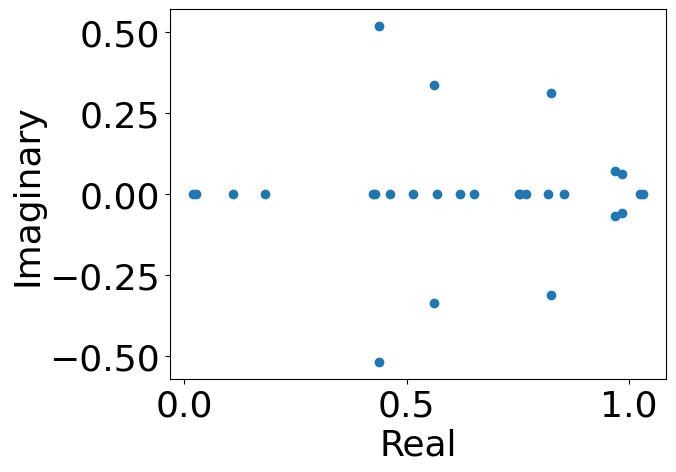

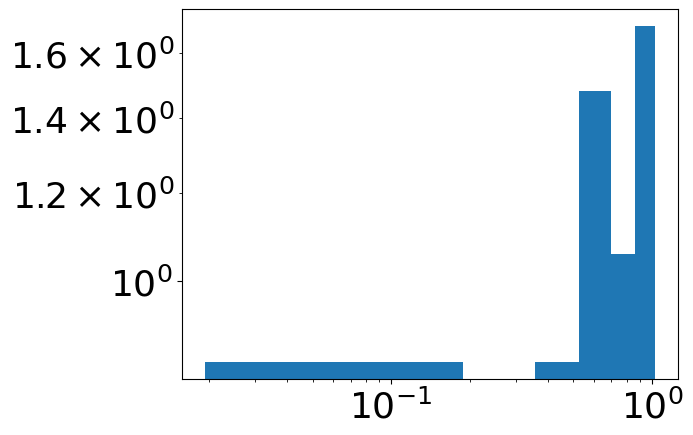

0.9522687457132515
percentage of chaos: 0.177
percentage of convergent: 0.0
398311.7426105588


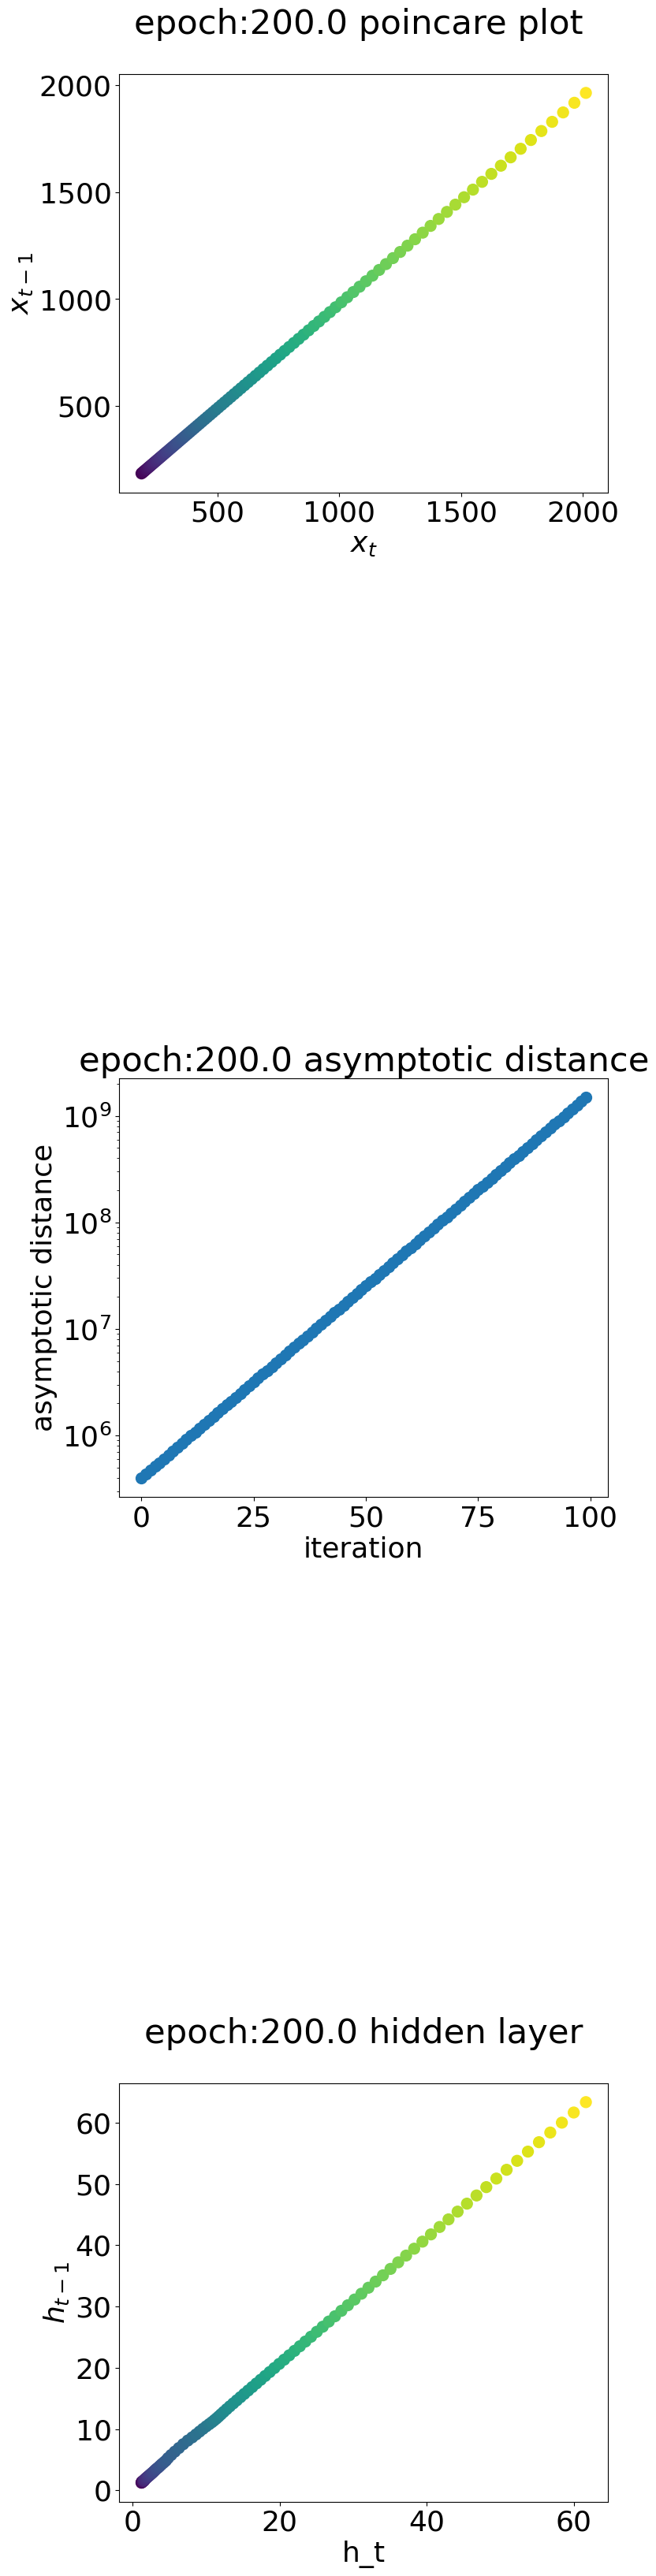

epoch : 201/1000, training loss = 0.012977,validation loss = 0.015142
epoch : 202/1000, training loss = 0.013033,validation loss = 0.015220
epoch : 203/1000, training loss = 0.013221,validation loss = 0.015386
epoch : 204/1000, training loss = 0.013384,validation loss = 0.015342
epoch : 205/1000, training loss = 0.013426,validation loss = 0.015306
epoch : 206/1000, training loss = 0.013420,validation loss = 0.015612
epoch : 207/1000, training loss = 0.013497,validation loss = 0.015405
epoch : 208/1000, training loss = 0.013451,validation loss = 0.015392
epoch : 209/1000, training loss = 0.013534,validation loss = 0.015522
epoch : 210/1000, training loss = 0.013554,validation loss = 0.015589
epoch : 211/1000, training loss = 0.013552,validation loss = 0.015992
epoch : 212/1000, training loss = 0.013437,validation loss = 0.015561
epoch : 213/1000, training loss = 0.013386,validation loss = 0.015305
epoch : 214/1000, training loss = 0.013286,validation loss = 0.015183
epoch : 215/1000, tr

In [ ]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=False
chao=[]
for epoch in range(epochs):
    loss = 0


    for batch_features, _ in train_loader:
        # reshape mini-batch data to [1000, 784] matrix
        # load it to the active device
        input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_features).view(batch_size, -1).to(device)
        #input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        #input_image=add_noise(torch.zeros(28,28,100).view(100,-1),noise_strength).to(device)
        #input_image=batch_features.view(batch_size,-1).to(device)
        batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,batch_feature)
        
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        if epoch==0 and init_compute:
            x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,batch_features.view(100,-1).to(device),epoch)
            for param in model.parameters():
                print(param.size())
            average_jacobian=[]
            spectral_radiuses=[]
            init_compute=False
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)
   # for i in batch_features:
    #    plt.imshow(i.view(28,28).cpu()*256)
     #   plt.show()
    
    # display the epoch training loss
    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
        
        
    print("epoch : {}/{}, training loss = {:.6f},validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        #name="asymptotic image input"
        #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
        #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
        perturbed_inputs=add_powerlaw_noise(input_size,batch_size,perturbation_strength,batch_features).view(batch_size, -1).to(device)
        distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*np.sqrt(input_size)*torch.max(x_train))
        print("percentage of chaos:",chaos) 
        print("percentage of convergent:",divergent/100)
        asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        
        print(distance[0])
        
        chao.append(chaos)
        diverge.append(divergent/100)
        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        
        plt.subplot(5, 1, 3)
        plt.scatter(range(no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance")
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        plt.subplot(5, 1, 5)
        #plt.figure().set_figheight(8)
        plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        plt.xlabel("h_t")
        plt.ylabel("$h_{t-1}$")
        #plt.yscale("log")
        plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+".jpg",bbox_inches = 'tight')
        plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)


In [ ]:
visualisation(input_image[0],0,"sample image with noise",True)
visualisation(batch_feature[0],0,"sample image without noise",True)

In [62]:
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)
print(chao)
print(diverge)

x=np.arange(1,epochs/intervals+1)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/"+str(interval))
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("percentage of image in chaos.jpg")

np.savetxt("percentage of chaos.txt",chao)
plt.show()









print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg")

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

#print("average jacobian")
#plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("average jacobian")
#plt.xlabel("epoch/"+str(interval))
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("average_jacobian.jpg")
#np.savetxt("average jacobian.txt",average_jacobian)
#plt.show()

print("spectral radius")
plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
plt.ylabel("spectral radius")
plt.xlabel("epoch/20")
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("spectral radius.jpg")

np.savetxt("spectral radius.txt",spectral_radiuses)
plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg")
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

[0.987, 0.959, 0.151, 0.414, 0.212, 0.224, 0.818, 0.026, 0.891, 0.177, 0.168, 0.725, 0.93, 0.874, 0.743, 0.797, 0.81, 0.872, 0.965, 0.901, 0.03, 0.594, 0.901, 0.884, 0.804, 0.886, 0.893, 0.851, 0.773, 0.882, 0.825, 0.008, 0.86, 0.816, 0.85, 0.001, 0.008, 0.798, 0.871, 0.179, 0.544, 0.834, 0.821, 0.78, 0.823, 0.835, 0.819, 0.848, 0.842, 0.901]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


NameError: name 'intervals' is not defined

In [ ]:
distance[1]

In [ ]:

validation_loss=[]
training_loss=[]
print("running")
for epoch in range(1,1001):
    loss = 0
    model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    PATH="epoch:"+str(epoch)+".pt"
    model.load_state_dict(torch.load(PATH))
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        
        
        
        input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        #input_image=batch_features.view(batch_size,-1).to(device)
      #  batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
       # optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        #outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        #train_loss = criterion(outputs,input_image)
        

        #loss += train_loss.item()
    # compute the epoch training loss
    #loss = loss / len(train_loader)
    #training_loss.append(loss)
    #with torch.no_grad():
     #   accuracy=validation(test_loader)
      #  validation_loss.append(accuracy)
    #if (epoch)%interval==interval-1:
     #   name="asymptotic image input"
        #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
      #  x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


       # dimension_vector=torch.ones(input_size).to(device)
        #xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
        perturbed_inputs=add_noise(input_image,perturbation_strength)
        #distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*input_size)
        #print("percentage of chaos:",chaos)
        #asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print("initial distance")
        #print(distance[0])
        #chao.append(chaos)
        #print(torch.norm(perturbed_inputs[0]-input_image[0]))
        #print(perturbation_strength*input_size)

plt.scatter(x,y=chao,label=labels)
plt.savefig("percentage of image in chaos.jpg")
plt.title("100 images")
plt.ylabel("percentage of images in chaos")
plt.xlabel("epoch/20")
np.savetxt("percentage of chaos.txt",chao)
plt.show()
    #model.eval()

In [ ]:
 print(perturbation_strength*input_size)

In [ ]:
my_file = open("average jacobian 1.txt", "r")
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
data_into_list = data.replace('\n', ' ').split(" ")
print(data_into_list[:-1])
data=[]
for i in range(len(data_into_list[:-1])):
    data.append(float(data_into_list[i]))
print(data)
x=np.arange(1,51)
labels="noise:{:F}\nperturbation:{:F}".format(10**-3,10**-6)
plt.scatter(x,y=data,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("average jacobian")
plt.xlabel("epoch/20")
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("average jacobian.jpg")

plt.show()